In [34]:
"""
WARNING!
EXTREMLY BAD CODING!
"""

import pandas as pd
import numpy as np
from scipy import stats
import os
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import glob
from lmfit.models import LorentzianModel
import math

plt.rcParams['figure.figsize'] = (10, 4)
plt.rcParams['lines.markersize'] = 5

In [19]:
def get_data(filename):
    measure1_data = pd.read_excel(filename, usecols = "A:C").to_numpy().T
    data_time = measure1_data[0]
    data_left = measure1_data[1]
    data_right = measure1_data[2]
    return [data_time, data_left, data_right]

In [20]:
def plot_pos_space(time, data_pos, title, colour):
    fig, ax = plt.subplots()
    ax.set(xlabel = 'Time (s)', ylabel = 'Amplitude/Voltage (V)', title = title)
    ax.plot(time, data_pos, color = colour)
    plt.show()

In [21]:
def simple_fft(data_left, data_right):
    fourier_left = np.abs(np.fft.fft(data_left))/len(data_left)
    fourier_right = np.abs(np.fft.fft(data_right))/len(data_right)
    return [fourier_left, fourier_right]

In [35]:
def trim_data(fourier_left, fourier_right, min_freq, max_freq, data_time):
    sampling_step = 0.005 #5000 micro seconds, hardcoded in LOL change that if you want
    N = len(data_time)
    frequency_spectrum = np.linspace(0, (N-1)*sampling_step, N)

    frequency_trimed = []
    fourier_left_trimed = [] 
    fourier_right_trimed = []
    
    for i in range(len(frequency_spectrum)):
        if frequency_spectrum[i] > min_freq and frequency_spectrum[i] < max_freq:
            frequency_trimed.append(frequency_spectrum[i])
            fourier_left_trimed.append(fourier_left[i])
            fourier_right_trimed.append(fourier_right[i])

    frequency_trimed = np.array(frequency_trimed)*(2*math.pi)
    fourier_left_trimed = np.array(fourier_left_trimed)*(2*math.pi)
    fourier_right_trimed = np.array(fourier_right_trimed)*(2*math.pi)
    
    return [frequency_trimed, fourier_left_trimed, fourier_right_trimed]

In [36]:
def simple_peaks(fourier_left_trimed, fourier_right_trimed, min_height):
    peaks_left, _ = find_peaks(fourier_left_trimed, height = min_height)
    peaks_right, _ = find_peaks(fourier_right_trimed, height = min_height)
    return [peaks_left, peaks_right]

In [81]:
def peak_fit(frequency_trimed, fourier_trimed, peaks_pos, num_of_peaks, title):
    if num_of_peaks == 1:
        mod_left = LorentzianModel()
        pars_left = mod_left.guess(fourier_trimed, x = frequency_trimed)
        out = mod_left.fit(fourier_trimed, pars_left, x = frequency_trimed)
        
        print(out.fit_report())
        plt.figure()
        plt.plot(frequency_trimed, fourier_trimed, 'g*')
        plt.plot(frequency_trimed, fourier_trimed, 'g-', label = 'Original Data')
        plt.plot(frequency_trimed, out.best_fit, 'r-', label='Lorentzian Mode')
        plt.legend(loc='best')
        plt.xlabel('Angular Frequncy Omega')
        plt.title(title)
        plt.show()

    elif num_of_peaks == 2:
        mod_1 = LorentzianModel(prefix='one_')
        pars = mod_1.guess(fourier_trimed, x = frequency_trimed)
        pars['one_center'].set(frequency_trimed[peaks_pos[0]])
        pars['one_amplitude'].set(fourier_trimed[peaks_pos[0]])

        mod_2 = LorentzianModel(prefix='two_')
        pars.update(mod_2.guess(fourier_trimed, x = frequency_trimed))
        pars['two_center'].set(frequency_trimed[peaks_pos[1]])
        pars['two_amplitude'].set(fourier_trimed[peaks_pos[1]])

        mod = mod_1 + mod_2
        init = mod.eval(pars, x = frequency_trimed)
        out = mod.fit(fourier_trimed, pars, x = frequency_trimed)
        
        print(out.fit_report())
        plt.figure()
        plt.plot(frequency_trimed, fourier_trimed, 'g*')
        plt.plot(frequency_trimed, fourier_trimed, 'g-', label = 'Original Data')
        #plt.plot(frequency_trimed, out.init_fit, 'k--', label = 'initial fit')
        plt.plot(frequency_trimed, out.best_fit, 'r-', label='Lorentzian Model')
        plt.legend(loc='best')
        plt.show()

In [82]:
def info(filename, min_freq, max_freq, min_height, num_of_peaks):
    data_time, data_left, data_right = get_data(filename)
    
    fourier_left, fourier_right = simple_fft(data_left, data_right)
    
    frequency_trimed, fourier_left_trimed, fourier_right_trimed = trim_data(fourier_left, fourier_right, min_freq, max_freq, data_time)
    
    peaks_left, peaks_right = simple_peaks(fourier_left_trimed, fourier_right_trimed, min_height)
    
    peak_fit(frequency_trimed, fourier_left_trimed, peaks_left, num_of_peaks, title = 'Left Pendulum')    
    
    peak_fit(frequency_trimed, fourier_right_trimed, peaks_right, num_of_peaks, title = 'Right Pendulum')
    
    plot_pos_space(data_time, data_left, title = 'Left Pendulum', colour = 'r')
    
    plot_pos_space(data_time, data_left, title = 'Right Pendulum', colour = 'tab:purple')

[[Model]]
    Model(lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 71
    # data points      = 199
    # variables        = 3
    chi-square         = 0.01912895
    reduced chi-square = 9.7597e-05
    Akaike info crit   = -1834.72156
    Bayesian info crit = -1824.84165
[[Variables]]
    amplitude:  0.05662863 +/- 0.00114465 (2.02%) (init = 1.984422)
    center:     2.84759958 +/- 6.0674e-04 (0.02%) (init = 2.858849)
    sigma:      0.03219439 +/- 0.00104116 (3.23%) (init = 1.036726)
    fwhm:       0.06438878 +/- 0.00208231 (3.23%) == '2.0000000*sigma'
    height:     0.55989416 +/- 0.01270437 (2.27%) == '0.3183099*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  =  0.719
    C(center, sigma)     =  0.243
    C(amplitude, center) =  0.122


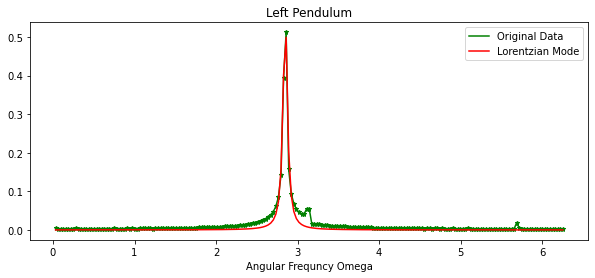

[[Model]]
    Model(lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 74
    # data points      = 199
    # variables        = 3
    chi-square         = 0.02325681
    reduced chi-square = 1.1866e-04
    Akaike info crit   = -1795.83792
    Bayesian info crit = -1785.95801
[[Variables]]
    amplitude:  0.05590055 +/- 0.00125714 (2.25%) (init = 1.965955)
    center:     2.84727202 +/- 6.5952e-04 (0.02%) (init = 2.858849)
    sigma:      0.03180715 +/- 0.00115996 (3.65%) (init = 1.036726)
    fwhm:       0.06361430 +/- 0.00231993 (3.65%) == '2.0000000*sigma'
    height:     0.55942450 +/- 0.01432603 (2.56%) == '0.3183099*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  =  0.719
    C(center, sigma)     =  0.240
    C(amplitude, center) =  0.121


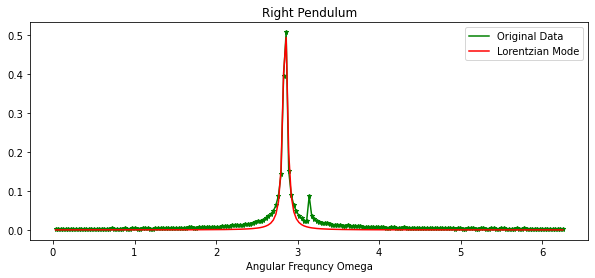

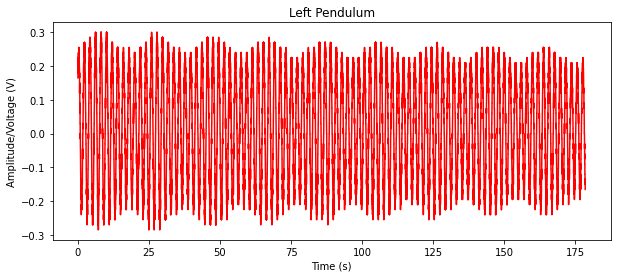

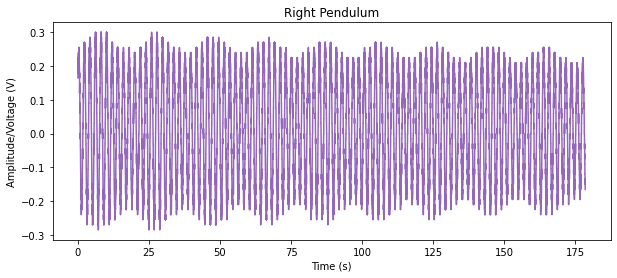

In [83]:
info('measure1.xlsx', 0, 1, 0.01, 1)

[[Model]]
    Model(lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 56
    # data points      = 199
    # variables        = 3
    chi-square         = 0.00338615
    reduced chi-square = 1.7276e-05
    Akaike info crit   = -2179.29223
    Bayesian info crit = -2169.41231
[[Variables]]
    amplitude:  0.01523233 +/- 4.7332e-04 (3.11%) (init = 1.562195)
    center:     3.14181618 +/- 0.00101224 (0.03%) (init = 3.141593)
    sigma:      0.01206679 +/- 3.7923e-04 (3.14%) (init = 1.036726)
    fwhm:       0.02413357 +/- 7.5845e-04 (3.14%) == '2.0000000*sigma'
    height:     0.40181388 +/- 0.00434117 (1.08%) == '0.3183099*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) =  0.940


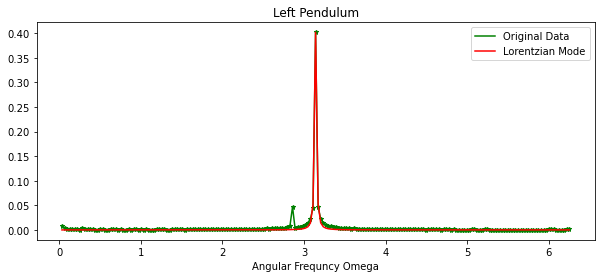

[[Model]]
    Model(lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 77
    # data points      = 199
    # variables        = 3
    chi-square         = 0.00648633
    reduced chi-square = 3.3094e-05
    Akaike info crit   = -2049.94126
    Bayesian info crit = -2040.06135
[[Variables]]
    amplitude:  0.01547971 +/- 6.4813e-04 (4.19%) (init = 1.564824)
    center:     3.14330452 +/- 0.00137532 (0.04%) (init = 3.141593)
    sigma:      0.01199092 +/- 6.1694e-04 (5.15%) (init = 1.036726)
    fwhm:       0.02398183 +/- 0.00123387 (5.15%) == '2.0000000*sigma'
    height:     0.41092311 +/- 0.01488848 (3.62%) == '0.3183099*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  =  0.717
    C(center, sigma)     = -0.534
    C(amplitude, center) =  0.135


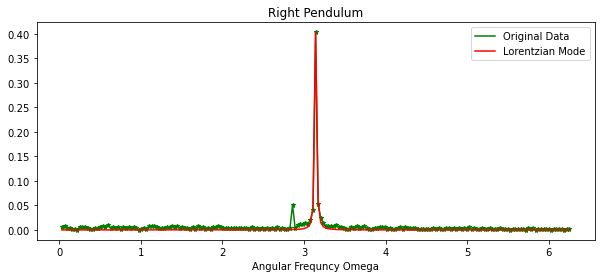

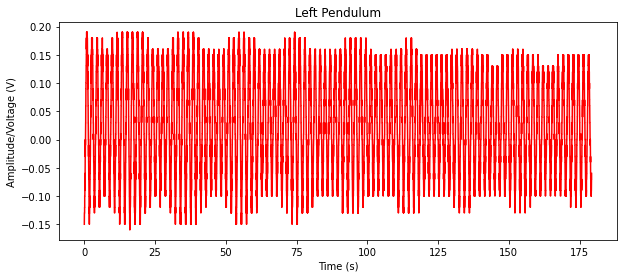

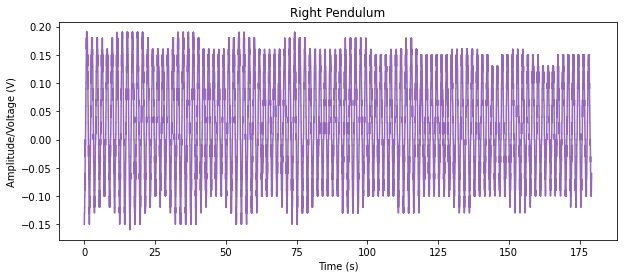

In [84]:
info('measure2.xlsx', 0, 1, 0.01, 1)

[[Model]]
    (Model(lorentzian, prefix='one_') + Model(lorentzian, prefix='two_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 179
    # data points      = 199
    # variables        = 6
    chi-square         = 0.00503956
    reduced chi-square = 2.6112e-05
    Akaike info crit   = -2094.16451
    Bayesian info crit = -2074.40468
[[Variables]]
    one_amplitude:  0.02320022 +/- 5.9207e-04 (2.55%) (init = 0.01251571)
    one_center:     3.16078688 +/- 7.0488e-04 (0.02%) (init = 2.607522)
    one_sigma:      0.03103263 +/- 0.00131708 (4.24%) (init = 0.1570796)
    one_fwhm:       0.06206526 +/- 0.00263416 (4.24%) == '2.0000000*one_sigma'
    one_height:     0.23797084 +/- 0.00705676 (2.97%) == '0.3183099*one_amplitude/max(1e-15, one_sigma)'
    two_amplitude:  0.02565987 +/- 5.3747e-04 (2.09%) (init = 0.2927754)
    two_center:     2.86729037 +/- 6.0134e-04 (0.02%) (init = 2.858849)
    two_sigma:      0.02590733 +/- 9.0558e-04 (3.50%) (init = 0.1570796

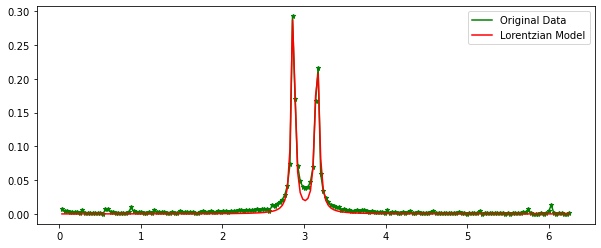

[[Model]]
    (Model(lorentzian, prefix='one_') + Model(lorentzian, prefix='two_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 153
    # data points      = 199
    # variables        = 6
    chi-square         = 0.00630530
    reduced chi-square = 3.2670e-05
    Akaike info crit   = -2049.57429
    Bayesian info crit = -2029.81446
[[Variables]]
    one_amplitude:  0.02518293 +/- 5.9426e-04 (2.36%) (init = 0.01046108)
    one_center:     2.86497285 +/- 7.4476e-04 (0.03%) (init = 2.450442)
    one_sigma:      0.02565704 +/- 8.8951e-04 (3.47%) (init = 0.1570796)
    one_fwhm:       0.05131407 +/- 0.00177902 (3.47%) == '2.0000000*one_sigma'
    one_height:     0.31242799 +/- 0.00763440 (2.44%) == '0.3183099*one_amplitude/max(1e-15, one_sigma)'
    two_amplitude:  0.02233855 +/- 6.3065e-04 (2.82%) (init = 0.0165053)
    two_center:     3.16409603 +/- 8.4092e-04 (0.03%) (init = 2.576106)
    two_sigma:      0.02901136 +/- 0.00129802 (4.47%) (init = 0.1570796

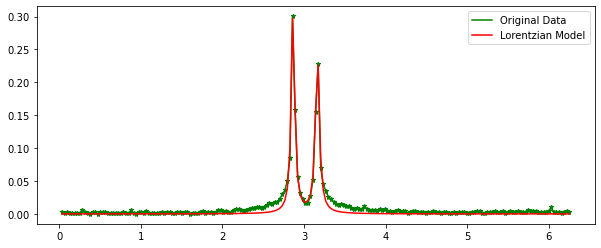

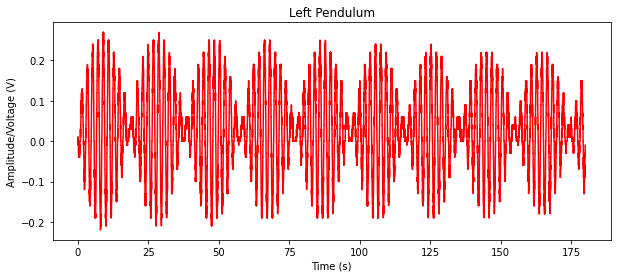

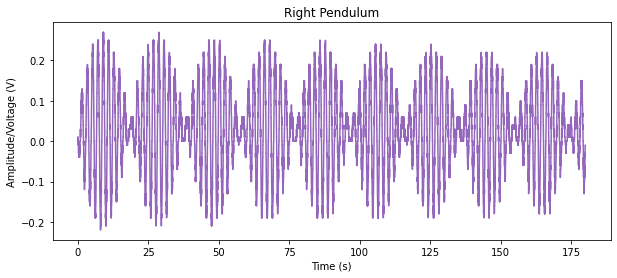

In [85]:
info('measure3.xlsx', 0, 1, 0.01, 2)

[[Model]]
    Model(lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 70
    # data points      = 199
    # variables        = 3
    chi-square         = 0.00515280
    reduced chi-square = 2.6290e-05
    Akaike info crit   = -2095.74247
    Bayesian info crit = -2085.86256
[[Variables]]
    amplitude:  0.02332893 +/- 5.1518e-04 (2.21%) (init = 1.838073)
    center:     2.95580021 +/- 7.3355e-04 (0.02%) (init = 2.953097)
    sigma:      0.01523598 +/- 4.4799e-04 (2.94%) (init = 1.036726)
    fwhm:       0.03047196 +/- 8.9599e-04 (2.94%) == '2.0000000*sigma'
    height:     0.48738770 +/- 0.01016031 (2.08%) == '0.3183099*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) =  0.707
    C(center, sigma)    = -0.575


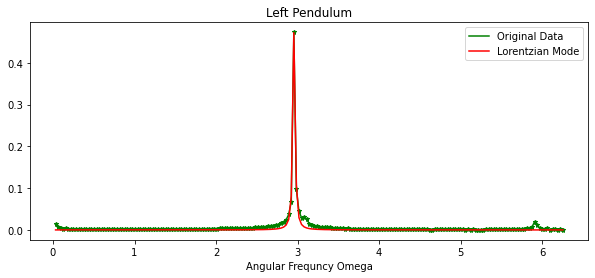

[[Model]]
    Model(lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 199
    # variables        = 3
    chi-square         = 0.00839357
    reduced chi-square = 4.2824e-05
    Akaike info crit   = -1998.64521
    Bayesian info crit = -1988.76530
[[Variables]]
    amplitude:  0.02265772 +/- 6.6622e-04 (2.94%) (init = 1.785589)
    center:     2.95490953 +/- 9.6883e-04 (0.03%) (init = 2.953097)
    sigma:      0.01550935 +/- 5.2957e-04 (3.41%) (init = 1.036726)
    fwhm:       0.03101871 +/- 0.00105913 (3.41%) == '2.0000000*sigma'
    height:     0.46502102 +/- 0.00959585 (2.06%) == '0.3183099*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) =  0.799
    C(center, sigma)    = -0.422


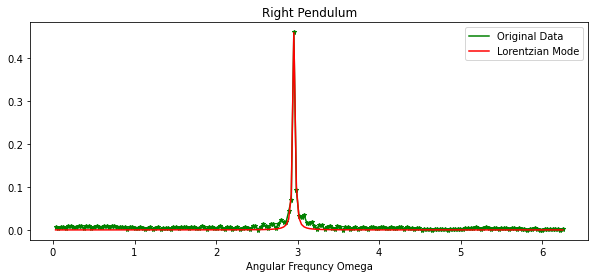

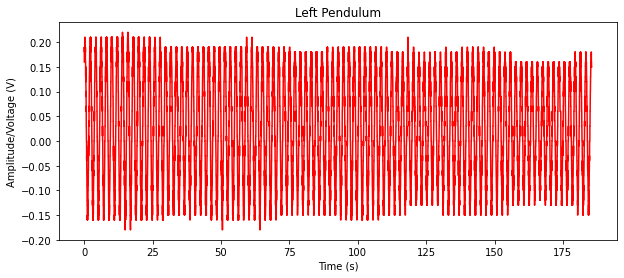

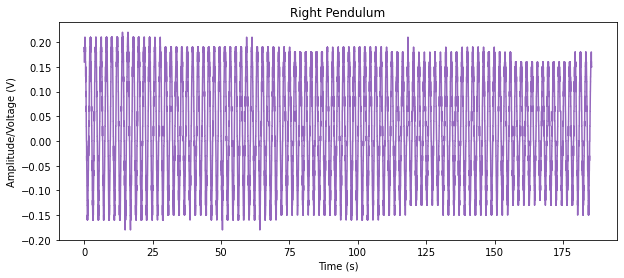

In [86]:
info('measure4.xlsx', 0, 1, 0.01, 1)

[[Model]]
    Model(lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 65
    # data points      = 199
    # variables        = 3
    chi-square         = 5.8215e-04
    reduced chi-square = 2.9701e-06
    Akaike info crit   = -2529.67564
    Bayesian info crit = -2519.79573
[[Variables]]
    amplitude:  0.00765055 +/- 2.1104e-04 (2.76%) (init = 0.8914333)
    center:     3.01657825 +/- 8.9758e-04 (0.03%) (init = 3.015929)
    sigma:      0.01058169 +/- 3.0610e-04 (2.89%) (init = 1.036726)
    fwhm:       0.02116338 +/- 6.1220e-04 (2.89%) == '2.0000000*sigma'
    height:     0.23013771 +/- 0.00295925 (1.29%) == '0.3183099*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) =  0.898
    C(center, sigma)    = -0.277


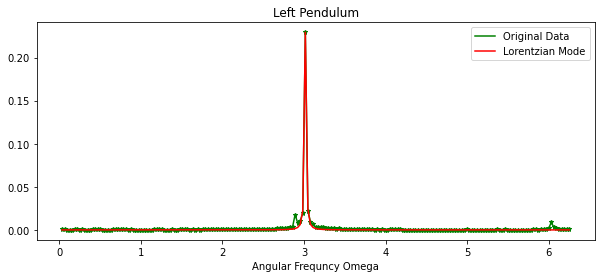

[[Model]]
    Model(lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 81
    # data points      = 199
    # variables        = 3
    chi-square         = 0.00613616
    reduced chi-square = 3.1307e-05
    Akaike info crit   = -2060.98544
    Bayesian info crit = -2051.10553
[[Variables]]
    amplitude:  0.00958278 +/- 5.9923e-04 (6.25%) (init = 0.8672244)
    center:     3.01724607 +/- 0.00205137 (0.07%) (init = 3.015929)
    sigma:      0.01353798 +/- 9.4364e-04 (6.97%) (init = 1.036726)
    fwhm:       0.02707595 +/- 0.00188728 (6.97%) == '2.0000000*sigma'
    height:     0.22531386 +/- 0.00876268 (3.89%) == '0.3183099*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) =  0.832
    C(center, sigma)    = -0.380


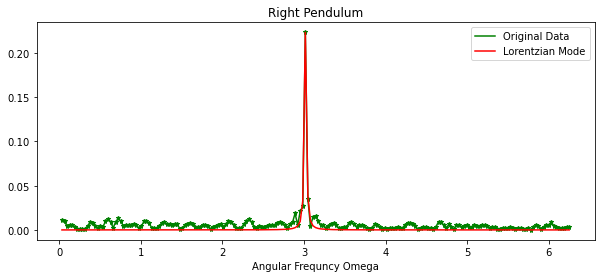

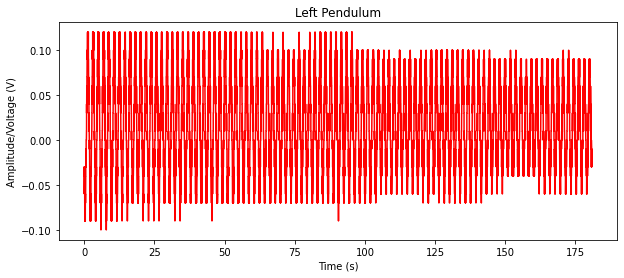

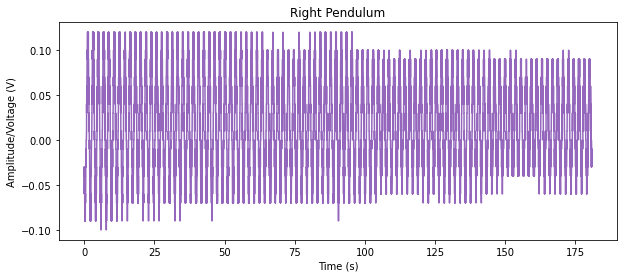

In [87]:
info('measure5.xlsx', 0, 1, 0.01, 1)

[[Model]]
    (Model(lorentzian, prefix='one_') + Model(lorentzian, prefix='two_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 78
    # data points      = 199
    # variables        = 6
    chi-square         = 0.00111957
    reduced chi-square = 5.8009e-06
    Akaike info crit   = -2393.53498
    Bayesian info crit = -2373.77515
[[Variables]]
    one_amplitude:  0.01275481 +/- 3.0792e-04 (2.41%) (init = 0.1143908)
    one_center:     2.87678920 +/- 5.9815e-04 (0.02%) (init = 2.890265)
    one_sigma:      0.03113034 +/- 0.00125434 (4.03%) (init = 0.07853982)
    one_fwhm:       0.06226069 +/- 0.00250868 (4.03%) == '2.0000000*one_sigma'
    one_height:     0.13041879 +/- 0.00346703 (2.66%) == '0.3183099*one_amplitude/max(1e-15, one_sigma)'
    two_amplitude:  0.00996121 +/- 2.5279e-04 (2.54%) (init = 0.1840548)
    two_center:     3.01089384 +/- 7.5794e-04 (0.03%) (init = 3.015929)
    two_sigma:      0.01629594 +/- 7.1367e-04 (4.38%) (init = 0.07853982

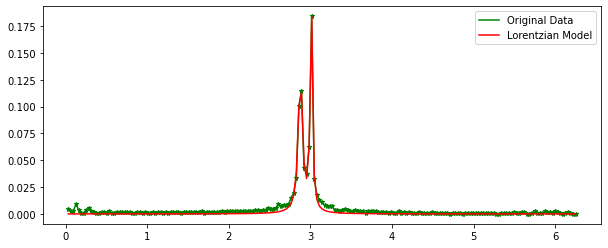

[[Model]]
    (Model(lorentzian, prefix='one_') + Model(lorentzian, prefix='two_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 476
    # data points      = 199
    # variables        = 6
    chi-square         = 0.00830322
    reduced chi-square = 4.3022e-05
    Akaike info crit   = -1994.79899
    Bayesian info crit = -1975.03916
[[Variables]]
    one_amplitude:  0.01025170 +/- 6.9393e-04 (6.77%) (init = 0.01516282)
    one_center:     2.87222536 +/- 0.00127607 (0.04%) (init = 0.1884956)
    one_sigma:      0.02322362 +/- 0.00366240 (15.77%) (init = 0.07853982)
    one_fwhm:       0.04644723 +/- 0.00732480 (15.77%) == '2.0000000*one_sigma'
    one_height:     0.14051287 +/- 0.01668638 (11.88%) == '0.3183099*one_amplitude/max(1e-15, one_sigma)'
    two_amplitude:  0.01178189 +/- 7.1572e-04 (6.07%) (init = 0.0126679)
    two_center:     3.01622423 +/- 0.00192966 (0.06%) (init = 1.225221)
    two_sigma:      0.02295173 +/- 0.00150150 (6.54%) (init = 0.07

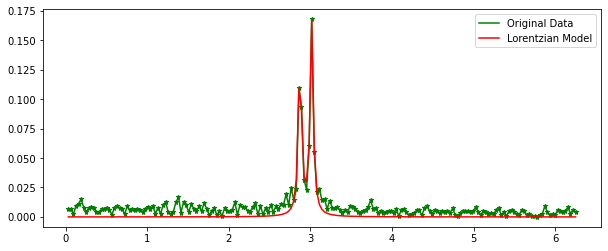

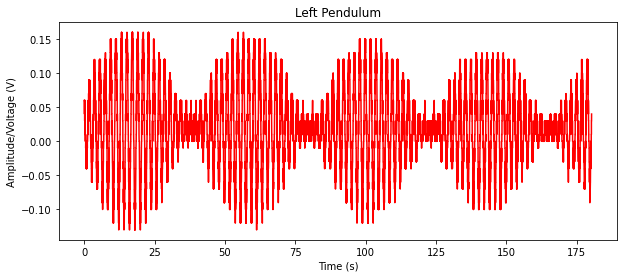

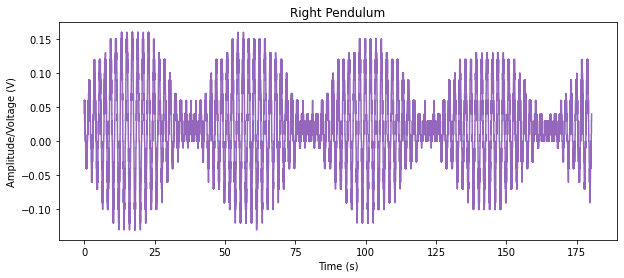

In [88]:
info('measure6.xlsx', 0, 1, 0.01, 2)

[[Model]]
    Model(lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 51
    # data points      = 199
    # variables        = 3
    chi-square         = 0.00769565
    reduced chi-square = 3.9264e-05
    Akaike info crit   = -2015.92059
    Bayesian info crit = -2006.04067
[[Variables]]
    amplitude:  0.03006457 +/- 5.8125e-04 (1.93%) (init = 1.733917)
    center:     2.88366104 +/- 6.0966e-04 (0.02%) (init = 2.890265)
    sigma:      0.01932695 +/- 7.1718e-04 (3.71%) (init = 1.036726)
    fwhm:       0.03865390 +/- 0.00143435 (3.71%) == '2.0000000*sigma'
    height:     0.49515569 +/- 0.01451956 (2.93%) == '0.3183099*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     =  0.709
    C(amplitude, sigma)  =  0.621
    C(amplitude, center) =  0.133


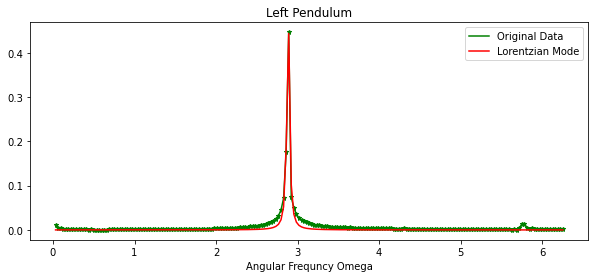

[[Model]]
    Model(lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 52
    # data points      = 199
    # variables        = 3
    chi-square         = 0.00557153
    reduced chi-square = 2.8426e-05
    Akaike info crit   = -2080.19457
    Bayesian info crit = -2070.31466
[[Variables]]
    amplitude:  0.03311873 +/- 5.5045e-04 (1.66%) (init = 1.57074)
    center:     2.88711531 +/- 5.6993e-04 (0.02%) (init = 2.890265)
    sigma:      0.02599943 +/- 5.3865e-04 (2.07%) (init = 1.036726)
    fwhm:       0.05199886 +/- 0.00107729 (2.07%) == '2.0000000*sigma'
    height:     0.40547124 +/- 0.00581164 (1.43%) == '0.3183099*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) =  0.726
    C(center, sigma)    =  0.301


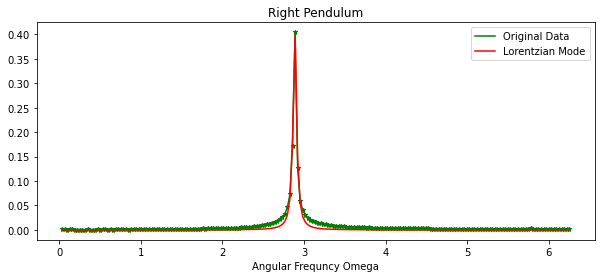

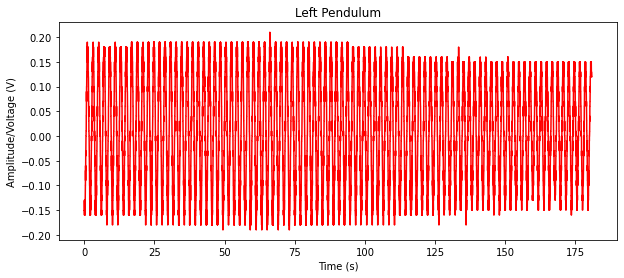

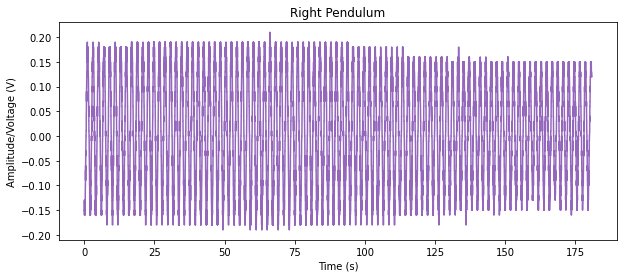

In [89]:
info('measure7.xlsx', 0, 1, 0.01, 1)

[[Model]]
    Model(lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 69
    # data points      = 199
    # variables        = 3
    chi-square         = 0.00371591
    reduced chi-square = 1.8959e-05
    Akaike info crit   = -2160.79878
    Bayesian info crit = -2150.91886
[[Variables]]
    amplitude:  0.02637362 +/- 4.9450e-04 (1.87%) (init = 0.977623)
    center:     3.08811433 +/- 5.8636e-04 (0.02%) (init = 3.078761)
    sigma:      0.03140748 +/- 9.1141e-04 (2.90%) (init = 1.036726)
    fwhm:       0.06281496 +/- 0.00182282 (2.90%) == '2.0000000*sigma'
    height:     0.26729255 +/- 0.00545834 (2.04%) == '0.3183099*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  =  0.714
    C(center, sigma)     = -0.311
    C(amplitude, center) = -0.148


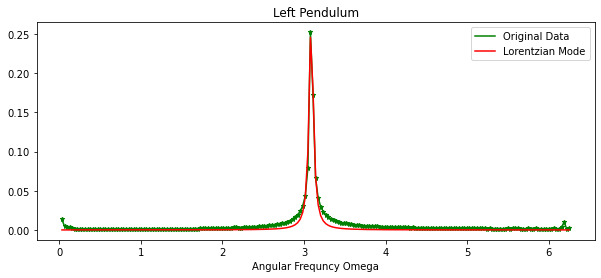

[[Model]]
    Model(lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 75
    # data points      = 199
    # variables        = 3
    chi-square         = 0.00409996
    reduced chi-square = 2.0918e-05
    Akaike info crit   = -2141.22638
    Bayesian info crit = -2131.34647
[[Variables]]
    amplitude:  0.02713524 +/- 5.0154e-04 (1.85%) (init = 1.066753)
    center:     3.08856367 +/- 5.3271e-04 (0.02%) (init = 3.078761)
    sigma:      0.02889539 +/- 8.7821e-04 (3.04%) (init = 1.036726)
    fwhm:       0.05779078 +/- 0.00175642 (3.04%) == '2.0000000*sigma'
    height:     0.29892018 +/- 0.00644794 (2.16%) == '0.3183099*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  =  0.712
    C(center, sigma)     = -0.382
    C(amplitude, center) = -0.176


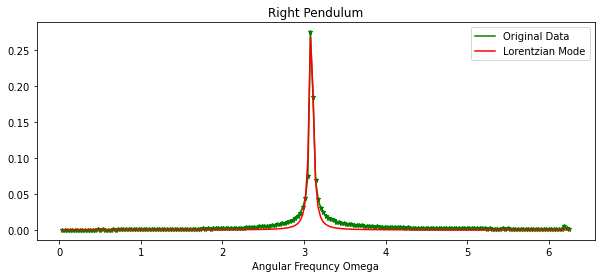

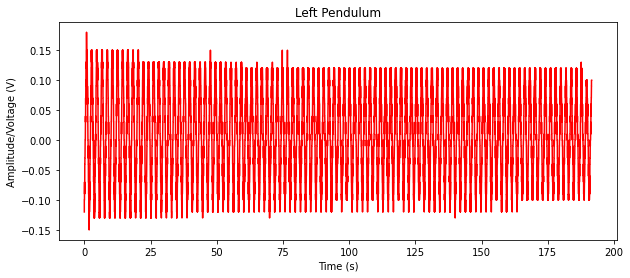

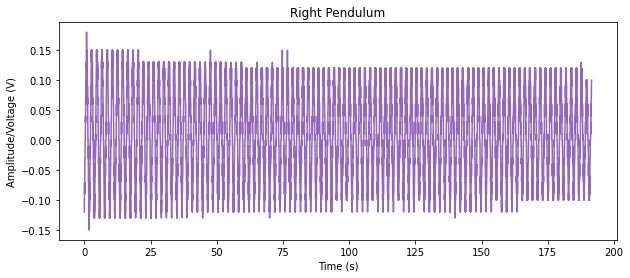

In [90]:
info('measure8.xlsx', 0, 1, 0.01, 1)

[[Model]]
    Model(lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 66
    # data points      = 199
    # variables        = 3
    chi-square         = 8.0003e-04
    reduced chi-square = 4.0818e-06
    Akaike info crit   = -2466.41009
    Bayesian info crit = -2456.53018
[[Variables]]
    amplitude:  0.01800246 +/- 2.2152e-04 (1.23%) (init = 0.7237839)
    center:     2.96933370 +/- 1.1163e-04 (0.00%) (init = 2.984513)
    sigma:      0.01360574 +/- 7.6618e-04 (5.63%) (init = 1.036726)
    fwhm:       0.02721148 +/- 0.00153235 (5.63%) == '2.0000000*sigma'
    height:     0.42117226 +/- 0.02792645 (6.63%) == '0.3183099*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = -0.775
    C(center, sigma)     =  0.238
    C(amplitude, center) = -0.234


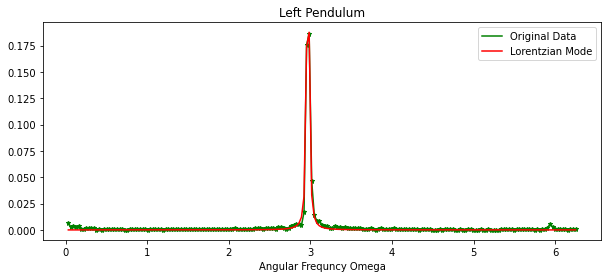

[[Model]]
    Model(lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 51
    # data points      = 199
    # variables        = 3
    chi-square         = 0.00130082
    reduced chi-square = 6.6368e-06
    Akaike info crit   = -2369.67533
    Bayesian info crit = -2359.79542
[[Variables]]
    amplitude:  0.01950953 +/- 1.8525e-04 (0.95%) (init = 0.8121314)
    center:     2.96785882 +/- 1.7056e-04 (0.01%) (init = 2.953097)
    sigma:      0.01767258 +/- 7.5842e-04 (4.29%) (init = 1.036726)
    fwhm:       0.03534516 +/- 0.00151685 (4.29%) == '2.0000000*sigma'
    height:     0.35139605 +/- 0.01440718 (4.10%) == '0.3183099*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) =  0.308
    C(center, sigma)    = -0.273


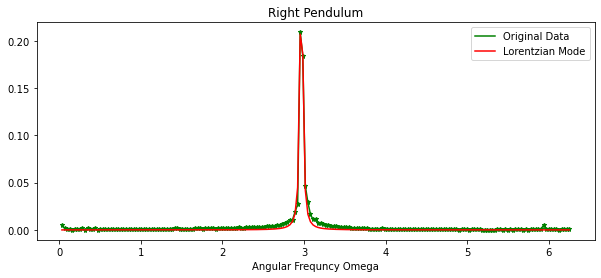

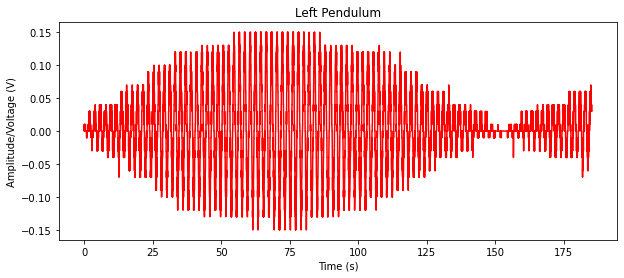

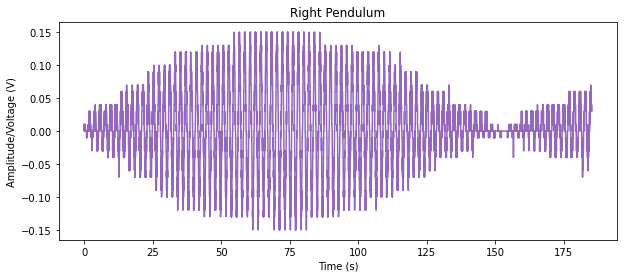

In [91]:
info('measure9.xlsx', 0, 1, 0.01, 1)